In [1]:
!pip install gymnasium matplotlib numpy atari-py gym[atari,accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 23.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for atari-py: filename=atari_py-0.2.9-cp310-cp310-linux_x86_64.whl size=2854845 sha256=52625f94f663c012e71b71c18b72056fd97ece4e9973bbc2210aa4e20f35141f
  Stored in directory: /root/.cache/pip/wheels/75/6f/04/1f3bf5255580101e16ff487564354dddcdd23ec3b43b775b7a
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446676 sha256=ab

In [2]:
import gym
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random as r
from random import random
import numpy as np
import torch.optim as optim
from torch.distributions.categorical import Categorical
from IPython.display import display, clear_output

In [52]:
maxtimesteps = 100000
episodes = 1400
critic_alpha = 0.0005
actor_alpha = 0.00001
gamma = 0.99
epsilon_min = 0.05
epsilon_max = 0.9
tau = 0.99
batch = 128
seed = 666
replaymemorysize = 3000
no_critic_update_until = 5000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hidden_dim = 128
no_updates = 1000
entropy_weight = 0.01
target_rewards = {'Pendulum-v1': -200,'CartPole-v1': 470, 'BipedalWalker-v3': 200, 'LunarLander-v2': 200,'MountainCar-v0': 110,"Acrobot-v1": -100}
print('DEVICE USED:', device)

DEVICE USED: cuda:0


In [53]:
class Actor(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Actor, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = nn.Linear(hidden_dim, output_dim)
  def forward(self,x):
     f1 = F.relu(self.fc1(x))
     f2 = F.relu(self.fc2(f1))
     f3 = F.softmax(self.fc3(f2),dim=1)
     return f3

class Critic(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Critic, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    f1 = F.relu(self.fc1(x))
    f2 = F.relu(self.fc2(f1))
    f3 = self.fc3(f2)
    return f3

In [54]:
class QActorCritic:
  def __init__(self, env):
    self.max_buffer_size = replaymemorysize
    np.random.seed(seed)
    torch.manual_seed(seed)
    self.gamma = gamma
    self.buffer = deque()
    self.env = env
    self.env.seed(seed)
    self.action_size = env.action_space.n 
    self.state_size = env.observation_space.shape[0]
    self.update_actor_after = no_critic_update_until
    self.batch_size = batch
    self.scores_deque = deque(maxlen=100)
    self.verbose = 0
    self.tau = tau 
    self.step = 0
    self.epsilon_min = epsilon_min
    self.epsilon = epsilon_max
    self.epsilon_decay = 0.999
    self.episodes = episodes
    self.maxsteps = maxtimesteps
    self.no_updates_until_buffer_full = no_updates
    self.critic = Critic(self.state_size, self.action_size)
    self.critic_target = Critic(self.state_size, self.action_size)
    self.actor = Actor(self.state_size, self.action_size)
    self.actor_target = Actor(self.state_size, self.action_size)
    self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_alpha)
    self.critic_optim = optim.Adam(self.critic.parameters(), lr=critic_alpha)
    self.env_raw = self.env.unwrapped.spec.id
    self.total_rewards, self.average_rewards = [],[]
        
  def obtain_Qvalue(self, network, state, action):
    #obtain actions at that index using the gather method. Try advance indexing as well
    index = action.reshape(-1,1).long()
    dim = 1
    value = network(state)
    return value.gather(1, index)
      
  def obtain_action(self, state, target= False, multiple= False):
    with torch.no_grad():
      if not target:
        action = Categorical(self.actor(state)).sample()
        if not multiple:
          return action.numpy()[0]
        else:
          return action
      else: 
        action = Categorical(self.actor_target(state)).sample()
        return action      
        
  def compute_critic_gradients(self, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones):
    with torch.no_grad():           
      next_actions = self.obtain_action(batch_next_states, target=True)
      targets = batch_rewards + (1-batch_dones)*(torch.tensor(self.gamma))*(self.obtain_Qvalue(self.critic_target, batch_next_states, next_actions).squeeze())
    predictions = self.obtain_Qvalue(self.critic, batch_states, batch_actions).squeeze()
    loss = F.mse_loss(predictions, targets)
    self.critic_optim.zero_grad()
    loss.backward()
    self.critic_optim.step()
    with torch.no_grad():
      self.soft_update(self.critic_target, self.critic, self.tau)
      self.soft_update(self.actor_target, self.actor, self.tau)
    return loss.detach().numpy()

  def soft_update(self,target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
      target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

  def hard_update(self,target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
      target_param.data.copy_(param.data)
      
  def compute_actor_gradients(self, batch_states):
    actions = self.obtain_action(batch_states, target=False, multiple= True)
    with torch.no_grad():
      q_vals = self.obtain_Qvalue(self.critic, batch_states, actions).squeeze()
    action_probs = self.actor(batch_states)
    action_logprobs = torch.clip(Categorical(action_probs).log_prob(actions), min=-10, max=10)
    loss = -torch.mean(q_vals*action_logprobs)
    self.actor_optim.zero_grad()
    loss.backward()
    self.actor_optim.step()
    return loss.detach().numpy()
  
  def train(self):
    actor_losses, critic_losses = [],[]
    total_rewards, average_rewards = [],[]
    for i in range(0,self.episodes):
      state = self.env.reset()
      episode_reward = 0
      terminated = False
      if self.epsilon*self.epsilon_decay < self.epsilon_min:
        self.epsilon = self.epsilon_min
      else:
        self.epsilon = self.epsilon*self.epsilon_decay
      while not terminated:
        self.step +=1
        reshaped_state = torch.from_numpy(state.reshape(-1, self.state_size)).float()
        if (random() < self.epsilon) or (self.step < self.update_actor_after):
          action = np.random.randint(self.action_size)
        else: action = agent.obtain_action(reshaped_state)
        observation, reward, terminated, _ = self.env.step(action)
        episode_reward += reward
        if len(self.buffer) >= self.max_buffer_size:
          self.buffer.pop()
        self.buffer.appendleft([state, action, reward, observation, terminated])
        actor_loss, critic_loss = None, None
        maxx = max(self.step,self.no_updates_until_buffer_full)
        current_timestep = self.step
        length = len(self.buffer)
        if maxx <= self.step and length>= self.batch_size:
          samplebatch = r.sample(self.buffer, self.batch_size)
          states, actions, rewards, next_states, dones = list(map(lambda x: np.array(x, dtype=np.float64), zip(*samplebatch)))
          states, actions, rewards, next_states, dones = tuple([torch.from_numpy(states).float(), torch.from_numpy(actions).float(), torch.from_numpy(rewards).float(), torch.from_numpy(next_states).float(),torch.from_numpy(dones).float()])
          critic_loss = self.compute_critic_gradients(states, actions, rewards, next_states, dones)
          if self.update_actor_after < current_timestep:
            actor_loss = self.compute_actor_gradients(states)
        if actor_loss and critic_loss:
          critic_losses.append(critic_loss)
          actor_losses.append(actor_loss)
        state = observation
      self.total_rewards.append(episode_reward)
      self.scores_deque.append(episode_reward)
      if np.mean(self.scores_deque) > target_rewards[self.env_raw]:
        print("Environment has been solved")
        print("Episode {}\tAverage Score: {:.2f},".format(i+1, np.mean(self.scores_deque))) 
    return self.total_rewards, self.average_rewards

In [15]:
env = gym.make('CartPole-v1')
agent = QActorCritic(env)
total_returns, average_returns = agent.train()

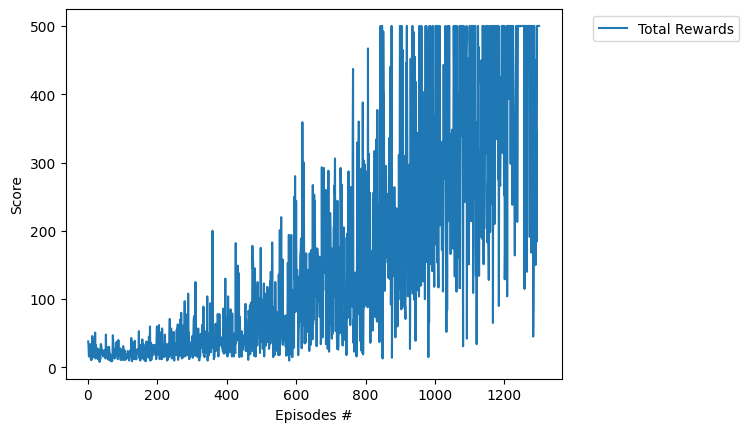

In [16]:
#Plotting total rewards per episode and average moving rewards for every 100 episodes on the same graph below
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(agent.total_rewards)+1-100), agent.total_rewards[100:], label="Total Rewards")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

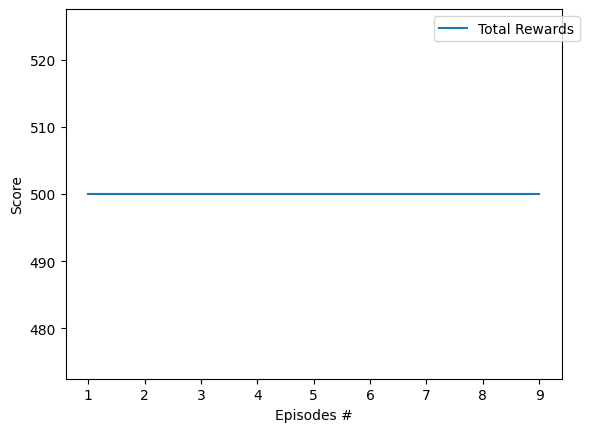

In [29]:
#Evaluation results for 10 episodes
episodes = 100
total_rewards = []
for i in range(1,10):
  terminated = False
  episode_reward = 0
  state = agent.env.reset()
  while not terminated:
    reshaped_state = torch.from_numpy(state.reshape(-1, agent.state_size)).float()
    action = torch.argmax(agent.actor(reshaped_state), dim=1).numpy()[0]
    state, reward, terminated, _ = agent.env.step(action)
    episode_reward += reward
  total_rewards.append(episode_reward)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_rewards)+1), total_rewards, label="Total Rewards")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()


In [30]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue repo

In [44]:
env = gym.make('LunarLander-v2')
agent = QActorCritic(env)
total_returns, average_returns = agent.train()

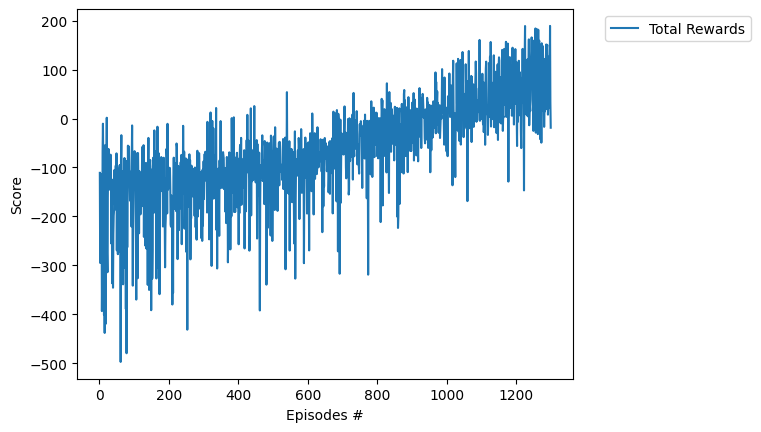

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(agent.total_rewards)+1-100), agent.total_rewards[100:], label="Total Rewards")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

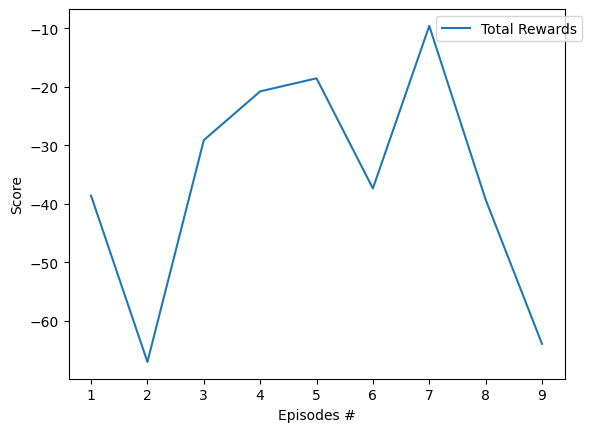

In [46]:
#Evaluation results for 10 episodes
episodes = 100
total_rewards = []
for i in range(1,10):
  terminated = False
  episode_reward = 0
  state = agent.env.reset()
  while not terminated:
    reshaped_state = torch.from_numpy(state.reshape(-1, agent.state_size)).float()
    action = torch.argmax(agent.actor(reshaped_state), dim=1).numpy()[0]
    state, reward, terminated, _ = agent.env.step(action)
    episode_reward += reward
  total_rewards.append(episode_reward)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_rewards)+1), total_rewards, label="Total Rewards")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [55]:
env = gym.make('Acrobot-v1')
agent = QActorCritic(env)
total_returns, average_returns = agent.train()

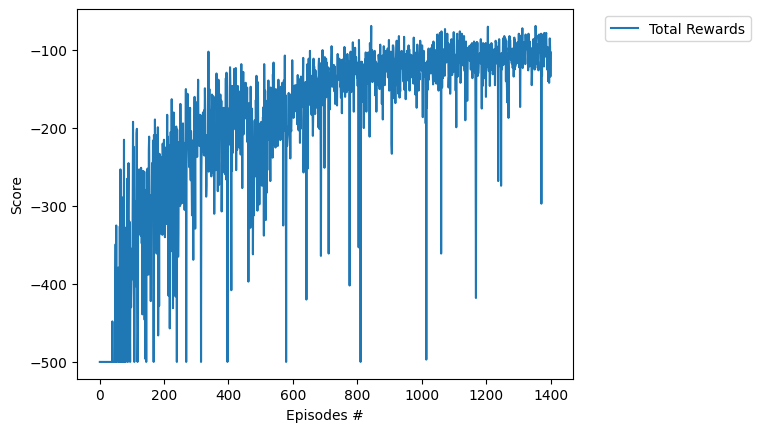

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(agent.total_rewards)+1), agent.total_rewards, label="Total Rewards")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

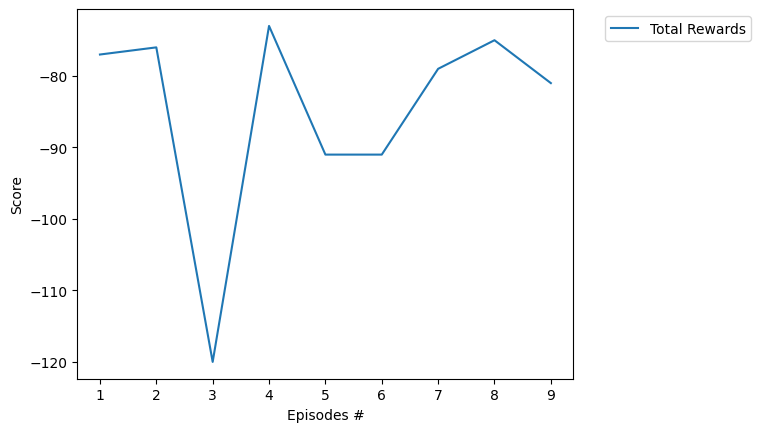

In [58]:
#Evaluation results for 10 episodes
episodes = 100
total_rewards = []
for i in range(1,10):
  terminated = False
  episode_reward = 0
  state = agent.env.reset()
  while not terminated:
    reshaped_state = torch.from_numpy(state.reshape(-1, agent.state_size)).float()
    action = torch.argmax(agent.actor(reshaped_state), dim=1).numpy()[0]
    state, reward, terminated, _ = agent.env.step(action)
    episode_reward += reward
  total_rewards.append(episode_reward)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_rewards)+1), total_rewards, label="Total Rewards")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()